## ANLP Assignment 1: Sentiment Analysis
### Arpan Mukhopadhyay,  a1797378

In [153]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
from nltk import word_tokenize
from nltk.probability import FreqDist
from langdetect import detect
import json
import re
from collections import Counter, defaultdict
import string

### 1. Reading dataset and initial pre-processing

In [154]:
#Cleaning out the original test and train datasets 
def langFilter(file,type:str):
    num = 0
    with open(f"hotel_review_en_{type}.JSON", "w") as out_file:
        with open(file,"r") as in_file:
            lines = in_file.readlines()
            for line in lines:
                num += 1
                # if num%100==0: print(num)
                json_line = json.loads(line)
                try:
                    lang = detect(json_line["text"])
                    if lang == "en":
                        out_file.write(line)
                except:
                    print("exception")
                    pass

#uncomment to generate JSON train and test sets of only english texts
# langFilter("hotel_reviews_train.JSON","train")
# langFilter("hotel_reviews_test.JSON","test")

In [233]:
original_data = pd.read_json('hotel_reviews_train.JSON', lines=True)
train_data = pd.read_json("hotel_review_en_train.JSON", lines=True)

#checking to see the difference in reviews after removal of non english reviews
print(len(original_data))
print(len(train_data))

24000
23999


In [234]:
test_data = pd.read_json("hotel_review_en_test.JSON", lines=True)
print(len(test_data))

6000


In [235]:
train_data.columns

Index(['ratings', 'title', 'text', 'author', 'date_stayed', 'offering_id',
       'num_helpful_votes', 'date', 'id', 'via_mobile'],
      dtype='object')

In [236]:
train_data['title']

0                             “Horrible experience”
1                                       “Stay Away”
2                      “Great location and service”
3                “I will never go back here again!”
4        “Ripped off our VISA card after departure”
                            ...                    
23994            “pleasant stay with good location”
23995     “Hit or miss, some things need attention”
23996                              “Good breakfast”
23997                    “Deserves a higher rating”
23998                        “Clean & comfortable!”
Name: title, Length: 23999, dtype: object

In [237]:
train_data['text'][0]

'First of all we got there and they didn\'t have the room we booked; did not pay us the difference from the room we booked to the cheaper one they gave us. STAFF took forever to address our problem, not KID friendly, pool dirty- and parking wow good luck going somewhere at night time and come back to the hotel to try to find a parking space THAT THEY CHARGE AN ADDITIONAL FEE FOR! (NOT INCLUDED IN THEIR OVERPRICED HOTEL STAY)\nWe thought by paying more we would get a good deal well this hotel is not the case!!\n$400 for a 2 night stay plus horrible customer service and a manager who never returned our call when we submitted the complain is not how you do business- They are giving SHERATON a horrible reputation- I guess they are managed by SHERATON but have their own "policies" and undesirable customer service.\nGreat time in San Diego but a nightmare of a hotel.\nDon\'t ever write reviews but this one was called for, if you can avoid this hotel do it.\n(Being a military family and movin

In [238]:
#omitting lowercase for now
def clean_text(text):
    if isinstance(text, str):
        text = re.sub(r'[^a-zA-Z0-9\s]','',text)
        text = re.sub(r'[\n\r\t]', ' ',text)
        text = re.sub(r'\s+', ' ', text)
        text.translate(text.maketrans('', '', string.punctuation)) #added just as a final sanity check if stuff was missed
        return text.strip()
    return ""

train_data['clean_title'] = train_data['title'].apply(clean_text)
train_data['clean_text'] = train_data['text'].apply(clean_text)

test_data['clean_title'] = test_data['title'].apply(clean_text)
test_data['clean_text'] = test_data['text'].apply(clean_text)

In [239]:
train_data['text'][0]

'First of all we got there and they didn\'t have the room we booked; did not pay us the difference from the room we booked to the cheaper one they gave us. STAFF took forever to address our problem, not KID friendly, pool dirty- and parking wow good luck going somewhere at night time and come back to the hotel to try to find a parking space THAT THEY CHARGE AN ADDITIONAL FEE FOR! (NOT INCLUDED IN THEIR OVERPRICED HOTEL STAY)\nWe thought by paying more we would get a good deal well this hotel is not the case!!\n$400 for a 2 night stay plus horrible customer service and a manager who never returned our call when we submitted the complain is not how you do business- They are giving SHERATON a horrible reputation- I guess they are managed by SHERATON but have their own "policies" and undesirable customer service.\nGreat time in San Diego but a nightmare of a hotel.\nDon\'t ever write reviews but this one was called for, if you can avoid this hotel do it.\n(Being a military family and movin

In [240]:
train_data['clean_text'][0]

'First of all we got there and they didnt have the room we booked did not pay us the difference from the room we booked to the cheaper one they gave us STAFF took forever to address our problem not KID friendly pool dirty and parking wow good luck going somewhere at night time and come back to the hotel to try to find a parking space THAT THEY CHARGE AN ADDITIONAL FEE FOR NOT INCLUDED IN THEIR OVERPRICED HOTEL STAY We thought by paying more we would get a good deal well this hotel is not the case 400 for a 2 night stay plus horrible customer service and a manager who never returned our call when we submitted the complain is not how you do business They are giving SHERATON a horrible reputation I guess they are managed by SHERATON but have their own policies and undesirable customer service Great time in San Diego but a nightmare of a hotel Dont ever write reviews but this one was called for if you can avoid this hotel do it Being a military family and moving from state to state we know

### 2. Exploratory Data Analysis (EDA)

In [241]:
print(train_data.columns)
print(test_data.columns)

Index(['ratings', 'title', 'text', 'author', 'date_stayed', 'offering_id',
       'num_helpful_votes', 'date', 'id', 'via_mobile', 'clean_title',
       'clean_text'],
      dtype='object')
Index(['ratings', 'title', 'text', 'author', 'date_stayed', 'offering_id',
       'num_helpful_votes', 'date', 'id', 'via_mobile', 'clean_title',
       'clean_text'],
      dtype='object')


In [242]:
train_data.head()

,ratings,title,text,author,date_stayed,offering_id,num_helpful_votes,date,id,via_mobile,clean_title,clean_text
0,"{'service': 1.0, 'cleanliness': 2.0, 'overall'...",“Horrible experience”,First of all we got there and they didn't have...,"{'username': 'Kh3RD', 'num_reviews': 1, 'id': ...",September 2012,80138,0,2012-09-19,140716137,False,Horrible experience,First of all we got there and they didnt have ...
1,"{'cleanliness': 1.0, 'sleep_quality': 1.0, 'ov...",“Stay Away”,Found Racist graffiti in the room. Request to ...,"{'username': 'TheUglyPhotographer', 'num_citie...",June 2011,240151,1,2011-06-27,114807323,False,Stay Away,Found Racist graffiti in the room Request to c...
2,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...",“Great location and service”,Close to Union Square - hotel is a bit of a ma...,"{'username': 'Moonstonemoclips', 'num_cities':...",October 2010,80793,0,2010-10-25,84805430,False,Great location and service,Close to Union Square hotel is a bit of a maze...
3,"{'service': 3.0, 'cleanliness': 2.0, 'overall'...",“I will never go back here again!”,I had a bad vibe about this place from the mom...,"{'username': 'JoanellenJ', 'num_cities': 10, '...",June 2012,111418,1,2012-06-28,132971117,False,I will never go back here again,I had a bad vibe about this place from the mom...
4,{'overall': 1.0},“Ripped off our VISA card after departure”,"After we received our ""final"" bill and left th...","{'username': 'Lynnworks', 'num_cities': 3, 'nu...",January 2012,671150,3,2012-02-04,124104157,False,Ripped off our VISA card after departure,After we received our final bill and left the ...


In [243]:
missing_overall_rating = train_data[~train_data['ratings'].apply(lambda x: 'overall' in x)]
missing_overall_rating

,ratings,title,text,author,date_stayed,offering_id,num_helpful_votes,date,id,via_mobile,clean_title,clean_text


In [244]:
max_words = train_data['clean_text'].apply(lambda x: len(str(x).split())).max()
mean_words = train_data['clean_text'].apply(lambda x: len(str(x).split())).mean()
min_words = train_data['clean_text'].apply(lambda x: len(str(x).split())).min()

print(f"Shortest review: {min_words} words", 
      f"\nAverage length of review: {round(mean_words,3)} words", 
      f"\nLongest review: {max_words} words")

Shortest review: 4 words 
Average length of review: 152.342 words 
Longest review: 2239 words


In [245]:
max_title_length = train_data['clean_title'].apply(lambda x: len(str(x).split())).max()
mean_title_length = train_data['clean_title'].apply(lambda x: len(str(x).split())).mean()
min_title_length = train_data['clean_title'].apply(lambda x: len(str(x).split())).min()

print(f"Shortest review title: {min_title_length} words", 
      f"\nAverage length of review title: {round(mean_title_length ,3)} words", 
      f"\nLongest review title: {max_title_length} words")

Shortest review title: 0 words 
Average length of review title: 4.822 words 
Longest review title: 26 words


In [246]:
row_data = train_data.loc[train_data['clean_title'] == '']
row_data

,ratings,title,text,author,date_stayed,offering_id,num_helpful_votes,date,id,via_mobile,clean_title,clean_text
2169,"{'service': 1.0, 'cleanliness': 5.0, 'overall'...","“!""”",We stayed in the W in Dallas twice. The first ...,"{'username': 'Chach63', 'num_cities': 15, 'num...",October 2011,600113,3,2012-07-06,133598143,False,,We stayed in the W in Dallas twice The first t...


In [247]:
# print(f"original title: {row_data['title'].iloc[0]},\ncleaned title: '{row_data['clean_title'].iloc[0]}' ")

In [248]:
row_data = train_data[train_data['clean_title'].str.split().str.len() == 1]
row_data

,ratings,title,text,author,date_stayed,offering_id,num_helpful_votes,date,id,via_mobile,clean_title,clean_text
15,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“Value”,"Doing an AM tour at Sony Studios, and the loca...","{'username': 'rwmentzer', 'num_cities': 16, 'n...",September 2012,248239,0,2012-09-28,141497337,False,Value,Doing an AM tour at Sony Studios and the locat...
26,"{'service': 5.0, 'cleanliness': 4.0, 'overall'...",“Fairmont-Dallas”,We had a most enjoyable short stay at this fin...,"{'username': 'Fred H', 'num_reviews': 1, 'id':...",October 2012,98606,0,2012-10-21,143365025,False,FairmontDallas,We had a most enjoyable short stay at this fin...
37,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“Excellent”,We had the misfortune of getting standed in Sa...,"{'username': 'NorthLincsChikky', 'num_cities':...",November 2009,79985,1,2009-11-08,48753878,False,Excellent,We had the misfortune of getting standed in Sa...
70,"{'service': 4.0, 'cleanliness': 4.0, 'overall'...",“wow”,"well, where to start? \nfirstly, the location,...","{'username': 'dexbrighton', 'num_cities': 2, '...",February 2007,93507,5,2007-02-19,6811836,False,wow,well where to start firstly the location that ...
85,"{'cleanliness': 5.0, 'value': 4.0, 'overall': ...",“Outstanding!”,Just back from a (2) day stay at the Omni. Aft...,"{'username': 'dje', 'num_cities': 10, 'num_hel...",May 2005,224948,7,2005-05-31,3514473,False,Outstanding,Just back from a 2 day stay at the Omni After ...
...,...,...,...,...,...,...,...,...,...,...,...,...
23799,{'overall': 2.0},“Sewage”,Unfortunately the room smelled like sewage. Ve...,"{'username': 'J W', 'num_reviews': 2, 'num_cit...",July 2012,87635,0,2012-07-20,134944668,False,Sewage,Unfortunately the room smelled like sewage Ver...
23806,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“Exceptional”,In addition to it being about a three minute w...,"{'username': 'Layover', 'num_cities': 102, 'nu...",March 2009,1157456,1,2009-05-11,29788756,False,Exceptional,In addition to it being about a three minute w...
23820,"{'service': 2.0, 'cleanliness': 1.0, 'overall'...",“Horrible”,Room doors that look like coffin lids. Sea foa...,"{'username': 'spanlaketraveler', 'num_cities':...",December 2007,214197,2,2007-12-08,11326781,False,Horrible,Room doors that look like coffin lids Sea foam...
23954,"{'cleanliness': 1.0, 'overall': 1.0, 'rooms': ...",“Seedy”,I was surprised to learn from the other review...,"{'username': '', 'id': '', 'location': ''}",April 2005,100561,9,2005-04-08,3343889,False,Seedy,I was surprised to learn from the other review...


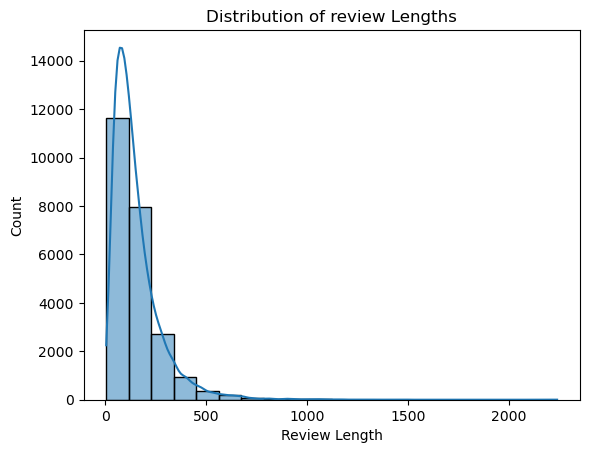

In [249]:
import seaborn as sns
train_data['text_length'] = train_data['clean_text'].apply(lambda x: len(x.split()))
sns.histplot(train_data['text_length'], bins=20, kde=True)
plt.title('Distribution of review Lengths')
plt.xlabel('Review Length')
plt.show()

In [ ]:
total_reviews = len(train_data)

reviews_upto_800 = len(train_data[train_data['text'].str.split().str.len() <= 800])
ratio = reviews_upto_800 / total_reviews
percentage = ratio * 100

print(f"Number of reviews with <=800 words: {reviews_upto_800}")
print(f"Total number of reviews: {total_reviews}")
print(f"Percentage of reviews with <=800 words: {percentage:.2f}%")

Number of reviews with <=800 words: 23908
Total number of reviews: 23999
Percentage of reviews with <=800 words: 99.62%


In [251]:
train_data = train_data[train_data['text'].str.split().str.len() <= 800].reset_index(drop=True)


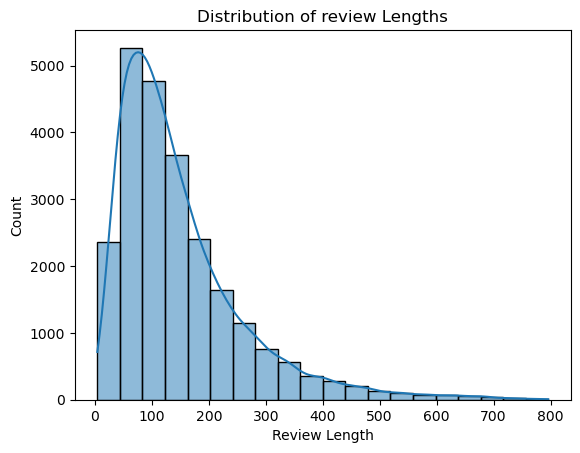

In [252]:
sns.histplot(train_data['text_length'], bins=20, kde=True)
plt.title('Distribution of review Lengths')
plt.xlabel('Review Length')
plt.show()

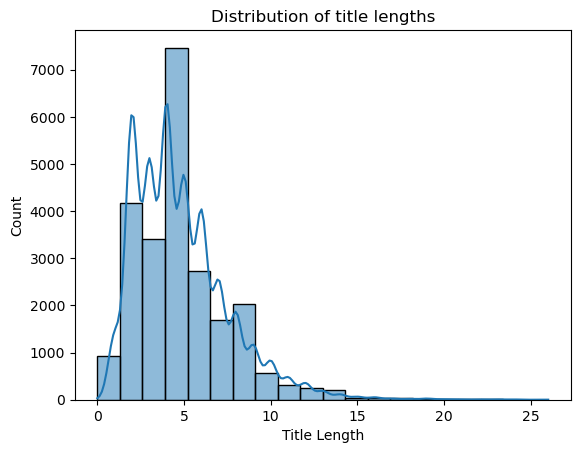

In [253]:
train_data['title_length'] = train_data['clean_title'].apply(lambda x: len(x.split()))
sns.histplot(train_data['title_length'], bins=20, kde=True)
plt.title('Distribution of title lengths')
plt.xlabel('Title Length')
plt.show()

[(5, 9804), (4, 7690), (3, 3274), (2, 1600), (1, 1540)]


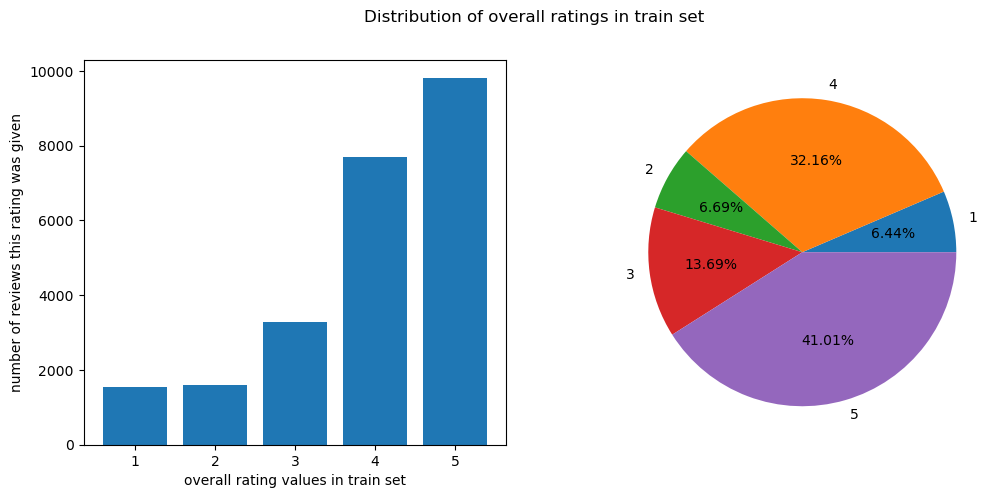

In [254]:
def overall_ratings_plot(data, type):
    ratings_distribution = []
    for i in range(len(data)):
        ratings_distribution.append(int(train_data['ratings'][i]['overall']))
    ratings_freq = Counter(ratings_distribution)
    print(sorted(ratings_freq.items(), key= lambda x:x[0], reverse=True))
    # total = sum(ratings_freq.values())
    # print(total)
    # print(f'{type} set ratings distribution:', ratings_freq)
    # ratios = [(val, round(cnt/total, 3)) for val, cnt in ratings_freq.items()]
    # print(f"percentage of dataset per rating: {sorted(ratios, key= lambda x:x[1], reverse = True)}")

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f'Distribution of overall ratings in {type} set')
    axes[0].bar(ratings_freq.keys(), ratings_freq.values())
    axes[0].set_xlabel(f'overall rating values in {type} set')
    axes[0].set_ylabel('number of reviews this rating was given')

    axes[1].pie (ratings_freq.values(), labels= ratings_freq.keys(), autopct='%1.2f%%')

overall_ratings_plot(train_data, 'train')

[(5, 2514), (4, 1880), (3, 832), (2, 407), (1, 367)]


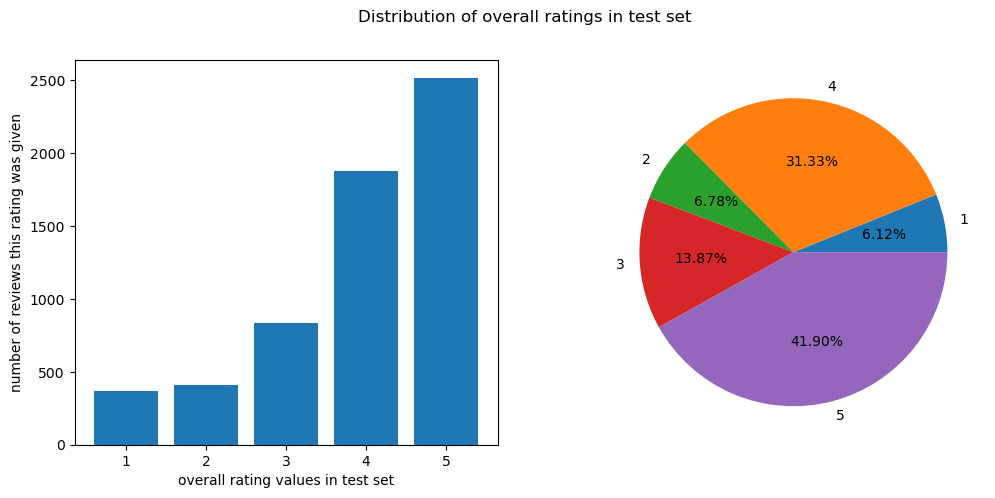

In [255]:
overall_ratings_plot(test_data, 'test')

In [256]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
train_data['stemmed_text'] = train_data['clean_text'].apply(lambda x: ' '.join([stemmer.stem(word) for word in word_tokenize(x)]))
train_data['stemmed_text']

0        first of all we got there and they didnt have ...
1        found racist graffiti in the room request to c...
2        close to union squar hotel is a bit of a maze ...
3        i had a bad vibe about thi place from the mome...
4        after we receiv our final bill and left the em...
                               ...                        
23903    we stay just one night here when visit our son...
23904    spent two night here with spous in conjunct wi...
23905    the room wa fairli larg pretti quiet the bed w...
23906    great start to our stay when we were check in ...
23907    great room comfort bed food is good the locat ...
Name: stemmed_text, Length: 23908, dtype: object

In [257]:
import spacy

nlp = spacy.load('en_core_web_sm')

#Noting: Lemmatization takes a while to run so running through pipe to speed it up (still takes ~2 mins)
def lemmatize(text):
    docs = list(nlp.pipe(text))
    return [' '.join([token.lemma_ for token in doc]) for doc in docs]

train_data['lemmatized_text'] = lemmatize(train_data['clean_text'])
train_data['lemmatized_text']

0        first of all we get there and they do not have...
1        find Racist graffiti in the room request to ch...
2        close to Union Square hotel be a bit of a maze...
3        I have a bad vibe about this place from the mo...
4        after we receive our final bill and leave the ...
                               ...                        
23903    we stay just one night here when visit our son...
23904    spend two night here with spouse in conjunctio...
23905    the room be fairly large pretty quiet the bed ...
23906    great start to our stay when we be check in 2h...
23907    great room comfortable bed food be good the lo...
Name: lemmatized_text, Length: 23908, dtype: object

In [258]:
a1 = train_data['stemmed_text'][4].split()
a2 = train_data['lemmatized_text'][4].split()
a3 = train_data['clean_text'][4].split()

print("Original Word | Stemmed Form | Lemmatized Form")
print("-" * 50)

for orig, stem, lemma in zip(a3, a1, a2):
    if stem != lemma:
        print(f"{orig:<13} | {stem:<12} | {lemma:<12}")


Original Word | Stemmed Form | Lemmatized Form
--------------------------------------------------
received      | receiv       | receive     
left          | left         | leave       
Empire        | empir        | Empire      
another       | anoth        | another     
charge        | charg        | charge      
accounting    | account      | accounting  
sent          | sent         | send        
justification | justif       | justification
response      | respons      | response    
company       | compani      | company     


using lemmatized text for further textual analysis as stemming can occasionally cut the actual word into its "stem" --> not very useful for model or eda

In [259]:
unique_words = set()
most_frequent_words = defaultdict(int)
for i in range(len(train_data)):
    data = train_data['clean_text'][i].split()
    for w in data:
        unique_words.add(w)
        most_frequent_words[w] += 1

#vocab size of 62493 unique words in all the reviews
print(f"number of unique words: {len(unique_words)}")

most_freq = sorted(most_frequent_words.items(), key=lambda x: x[1], reverse=True)
print(f"most frequent words use in reviews: {most_freq[:10]}") #Notice how all of them are stop words --> dataset needs pruning

number of unique words: 61428
most frequent words use in reviews: [('the', 187371), ('and', 124766), ('a', 101285), ('to', 91224), ('was', 78448), ('I', 57658), ('in', 56170), ('of', 48668), ('The', 47088), ('is', 45081)]


In [260]:
unique_words = set()
all_words = []
for i in range(len(train_data)):
    data = word_tokenize(train_data['clean_text'][i])
    for w in data:
        unique_words.add(w)
        all_words.append(w)

#vocab size of 62493 unique words in all the reviews
print(f"number of unique words: {len(unique_words)}")

#Note these are all stop words so should probably prune the dataset for stop words before looking for most common words
fdist = FreqDist(all_words)
fdist.most_common(10)

number of unique words: 61423


[('the', 187371),
 ('and', 124766),
 ('a', 101285),
 ('to', 91224),
 ('was', 78448),
 ('I', 57658),
 ('in', 56170),
 ('of', 48668),
 ('The', 47088),
 ('is', 45081)]

In [261]:
unique_words = set()
all_words = []
for i in range(len(train_data)):
    data = word_tokenize(train_data['lemmatized_text'][i])
    for w in data:
        unique_words.add(w)
        all_words.append(w)

#vocab size of 62493 unique words in all the reviews
print(f"number of unique words: {len(unique_words)}")

#Note these are all stop words so should probably prune the dataset for stop words before looking for most common words
fdist = FreqDist(all_words)
fdist.most_common(10)

number of unique words: 53111


[('the', 234659),
 ('be', 195041),
 ('and', 126325),
 ('a', 103524),
 ('to', 91731),
 ('I', 70720),
 ('we', 59842),
 ('in', 57641),
 ('of', 48863),
 ('room', 45918)]

In [262]:
unique_words = set()
most_frequent_words = defaultdict(int)
for i in range(len(train_data)):
    data = train_data['lemmatized_text'][i].split()
    for w in data:
        unique_words.add(w)
        most_frequent_words[w] += 1

#vocab size of 62493 unique words in all the reviews
print(f"number of unique words: {len(unique_words)}")

most_freq = sorted(most_frequent_words.items(), key=lambda x: x[1], reverse=True)
print(f"most frequent words use in reviews: {most_freq[:10]}") #Notice how all of them are stop words --> dataset needs pruning

number of unique words: 53110
most frequent words use in reviews: [('the', 234659), ('be', 195041), ('and', 126325), ('a', 103524), ('to', 91731), ('I', 70720), ('we', 59842), ('in', 57641), ('of', 48863), ('room', 45918)]


In [263]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def most_common_words(N:list):
    most_frequent_actual_words = []

    for n in N:
        if n[0].lower() not in stop_words:
            most_frequent_actual_words.append(n)
        if len(most_frequent_actual_words) == 10:
            break

    return most_frequent_actual_words

most_frequent_actual_words = most_common_words(most_freq)
most_frequent_actual_words

[('room', 45918),
 ('hotel', 43132),
 ('stay', 28878),
 ('great', 15846),
 ('staff', 14047),
 ('would', 13859),
 ('good', 13696),
 ('get', 13518),
 ('night', 12273),
 ('nice', 11413)]

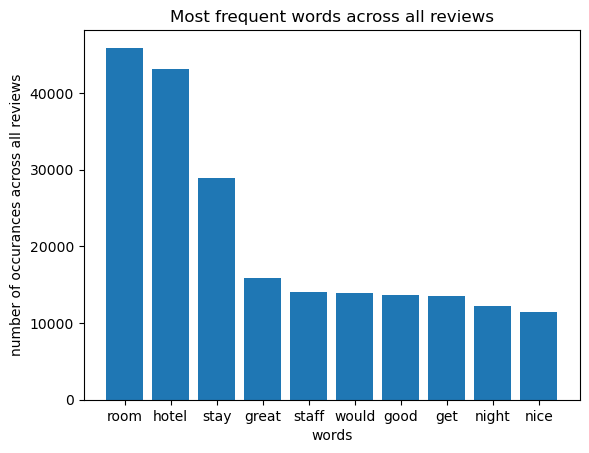

In [264]:
def plot_words(words, title_text, y_axis_text):
    words, counts = zip(*words)
    plt.bar(words, counts)
    plt.xlabel('words')
    plt.ylabel(y_axis_text)
    plt.title(title_text)

plot_words(most_frequent_actual_words,'Most frequent words across all reviews', 'number of occurances across all reviews')

In [265]:
def most_common_words_sentiment(N:list):
    negative_words = []
    positive_words = []
    for i in range(len(N)):
        data = word_tokenize(N['lemmatized_text'][i])
        rating = int(N['ratings'][i]['overall'])
        for w in data:
            if w.lower() in stop_words: continue
            if rating >= 2.5:
                positive_words.append(w)
            else:
                negative_words.append(w)
    
    return Counter(positive_words), Counter(negative_words)

positive_review_words, negative_review_words = most_common_words_sentiment(train_data)

print("Most common words in positive reviews: ")
positive_review_words.most_common(10)

Most common words in positive reviews: 


[('room', 37382),
 ('hotel', 36751),
 ('stay', 24833),
 ('great', 15179),
 ('staff', 12626),
 ('good', 12402),
 ('would', 11196),
 ('get', 10807),
 ('nice', 10485),
 ('night', 9924)]

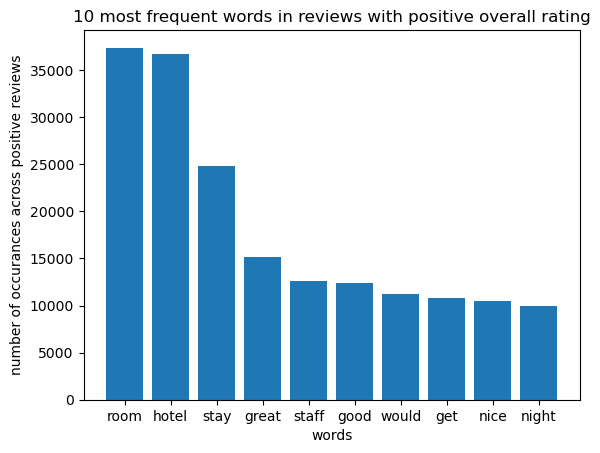

In [266]:
plot_words(positive_review_words.most_common(10),'10 most frequent words in reviews with positive overall rating', 'number of occurances across positive reviews')

In [267]:
print("Most common words in negative reviews:")
negative_review_words.most_common(10)

Most common words in negative reviews:


[('room', 8536),
 ('hotel', 6381),
 ('stay', 4045),
 ('get', 2711),
 ('would', 2663),
 ('night', 2349),
 ('one', 2139),
 ('go', 1984),
 ('could', 1586),
 ('desk', 1560)]

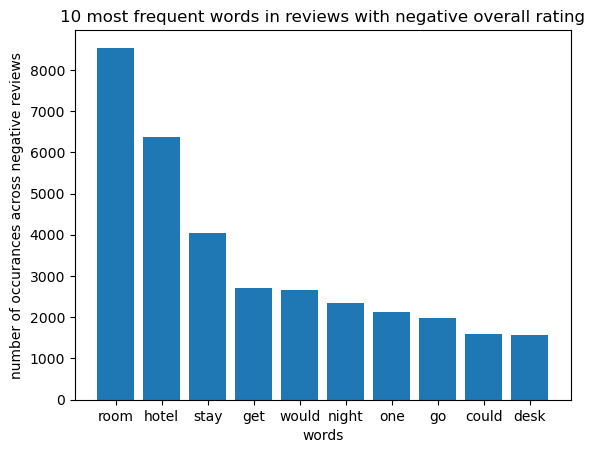

In [268]:
plot_words(negative_review_words.most_common(10),'10 most frequent words in reviews with negative overall rating', 'number of occurances across negative reviews')

In [269]:
from nltk import ngrams
n = 3
def generate_ngrams(text, n):
    n_grams = ngrams(text, n)
    return [' '.join(gram) for gram in n_grams]

n_grams_list = []
for i in range(len(train_data)):
    data = word_tokenize(train_data['clean_text'][i])
    n_grams = generate_ngrams(data, n)
    for gram in n_grams:
        n_grams_list.append(gram)

n_gram_freq = Counter(n_grams_list)

print(f"Distribution of {n}-grams:")
for ngram, count in n_gram_freq.most_common(10):
    print(f"{ngram}: {count}")

Distribution of 3-grams:
The room was: 2924
the front desk: 2832
in the room: 2132
of the hotel: 2019
The hotel is: 2017
stay here again: 1686
stayed at the: 1590
at this hotel: 1574
the room was: 1534
one of the: 1450


In [270]:
n = 3
def generate_ngrams(text, n):
    n_grams = ngrams(text, n)
    return [' '.join(gram) for gram in n_grams]

n_grams_list = []
for i in range(len(train_data)):
    data = word_tokenize(train_data['lemmatized_text'][i])
    n_grams = generate_ngrams(data, n)
    for gram in n_grams:
        n_grams_list.append(gram)

n_gram_freq = Counter(n_grams_list)

print(f"Distribution of {n}-grams:")
for ngram, count in n_gram_freq.most_common(10):
    print(f"{ngram}: {count}")

Distribution of 3-grams:
the room be: 8564
the hotel be: 5364
the staff be: 4225
stay at the: 3552
the front desk: 3532
there be a: 3278
I do not: 2598
in the room: 2536
it be a: 2512
this hotel be: 2339


Not very useful. What if we look at the most common tri grams for both "positive" and negative reviews?


In [271]:
positive_ngrams = []
negative_ngrams = []
for i in range(len(train_data)):
    data = word_tokenize(train_data['clean_text'][i])
    n_grams = generate_ngrams(data, n)
    rating = int(train_data['ratings'][i]['overall'])
    if rating >= 2.5:
        for gram in n_grams:
            positive_ngrams.append(gram)
    else:
        for gram in n_grams:
            negative_ngrams.append(gram)

positive_ngrams_freq = Counter(positive_ngrams)
negative_ngrams_freq = Counter(negative_ngrams)

print(f"Most common {n}-grams for positive rating reviews:")
for ngram, count in positive_ngrams_freq.most_common(10):
    print(f"{ngram}: {count}")
print('\n')
print(f"Most common {n}-grams for negative rating reviews:")
for ngram, count in negative_ngrams_freq.most_common(10):
    print(f"{ngram}: {count}")


Most common 3-grams for positive rating reviews:
The room was: 2641
the front desk: 1995
The hotel is: 1885
of the hotel: 1744
in the room: 1642
stay here again: 1560
stayed at the: 1436
at this hotel: 1297
the room was: 1280
and it was: 1263


Most common 3-grams for negative rating reviews:
the front desk: 837
in the room: 490
The room was: 283
at this hotel: 277
of the hotel: 275
I had to: 259
the room was: 254
to the front: 210
we had to: 210
one of the: 201


In [272]:
positive_ngrams = []
negative_ngrams = []
for i in range(len(train_data)):
    data = word_tokenize(train_data['lemmatized_text'][i])
    n_grams = generate_ngrams(data, n)
    rating = int(train_data['ratings'][i]['overall'])
    if rating >= 2.5:
        for gram in n_grams:
            positive_ngrams.append(gram)
    else:
        for gram in n_grams:
            negative_ngrams.append(gram)

positive_ngrams_freq = Counter(positive_ngrams)
negative_ngrams_freq = Counter(negative_ngrams)

print(f"Most common {n}-grams for positive rating reviews:")
for ngram, count in positive_ngrams_freq.most_common(10):
    print(f"{ngram}: {count}")
print('\n')
print(f"Most common {n}-grams for negative rating reviews:")
for ngram, count in negative_ngrams_freq.most_common(10):
    print(f"{ngram}: {count}")


Most common 3-grams for positive rating reviews:
the room be: 7552
the hotel be: 4826
the staff be: 3946
stay at the: 3163
there be a: 2839
the front desk: 2587
it be a: 2243
the location be: 2150
I do not: 2026
in the room: 1971


Most common 3-grams for negative rating reviews:
the room be: 1012
the front desk: 945
I do not: 572
in the room: 565
the hotel be: 538
there be no: 507
there be a: 439
stay at the: 389
this hotel be: 369
I have to: 335


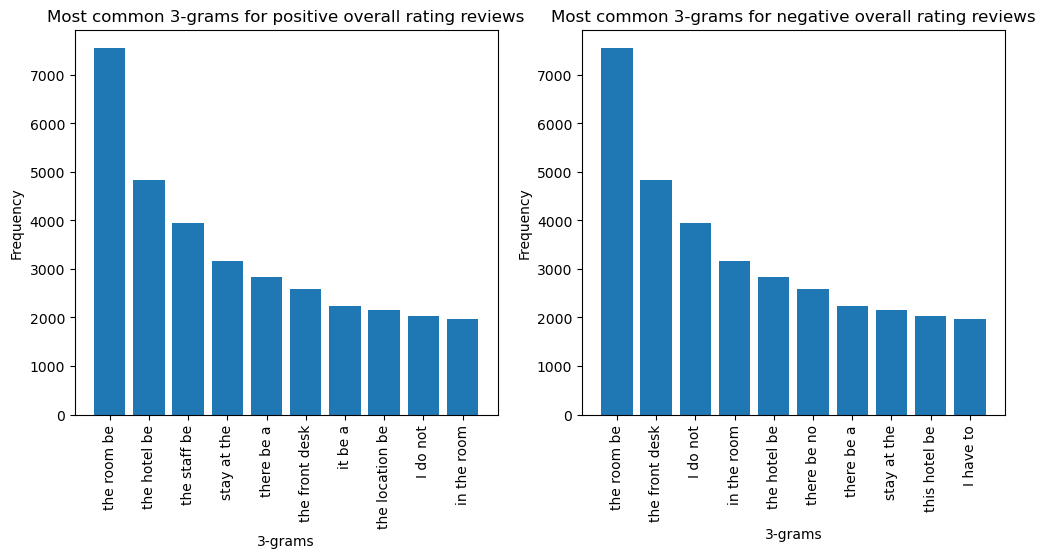

In [273]:
labels_pos, values_pos = zip(*positive_ngrams_freq.most_common(10))
labels_neg, values_neg = zip(*negative_ngrams_freq.most_common(10))
indexes = range(len(labels_pos))

lables = [labels_pos, labels_neg]
values = [values_pos, values_pos]

titles = [f"Most common {n}-grams for positive overall rating reviews", f"Most common {n}-grams for negative overall rating reviews"]
def multi_graph(indexes, labels, values, count, titles):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    for i in range(count):
        axes[i].bar(indexes, values[i])
        axes[i].set_xlabel(f'{n}-grams')
        axes[i].set_ylabel('Frequency')
        axes[i].set_xticks(indexes, labels[i], rotation='vertical')
        axes[i].set_title(titles[i])

multi_graph(indexes, lables, values, 2, titles)

In [274]:
titles = train_data['clean_title']
title_words = []
for n in train_data['clean_title']:
    title = word_tokenize(n)
    for w in title:
        title_words.append(w.lower())

print(Counter(title_words).most_common(10))

[('great', 5970), ('hotel', 5159), ('location', 3983), ('the', 3170), ('a', 3056), ('and', 2656), ('stay', 2607), ('in', 2109), ('good', 2083), ('for', 1975)]


In [275]:
title_words_ns = []
for n in train_data['clean_title']:
    title = word_tokenize(n)
    for w in title:
        if w.lower() not in stop_words:
            title_words_ns.append(w.lower())
            
print(Counter(title_words_ns).most_common(10))

[('great', 5970), ('hotel', 5159), ('location', 3983), ('stay', 2607), ('good', 2083), ('nice', 1653), ('service', 1393), ('staff', 1115), ('excellent', 1079), ('place', 1075)]


Based off all these experiments, it becomes apparent that some additional changes must be made to the data before being fed into a machine learning model. Given the consistant requirement of lowercasing the words for both the title and the text, all the text should be normalised through lowercasing. Though this might remove some of the "textual emotion" conveyed in some of the reviews as capital letters could indicate both excitement and anger. But also these are not terribly useful considering how similar the good and the bad reviews seem to be in terms of word similar. So rather than frequency or even n-gram maybe we need to look deeper

### 3. Selection and training Machine Learning models

In [276]:
train_data['lemmatized_text'] = train_data['lemmatized_text'].apply(lambda x: x.lower())
train_data['clean_title'] = train_data['clean_title'].apply(lambda x: x.lower())

In [277]:
train_data['clean_title'] = lemmatize(train_data['clean_title'])

In [278]:
def get_overall(ratings):
    try:
        return int(ratings.get('overall',None))
    except(AttributeError, TypeError):
        return None

train_data['overall'] = train_data['ratings'].apply(get_overall)
train_data['overall']

0        1
1        1
2        4
3        2
4        1
        ..
23903    4
23904    3
23905    5
23906    4
23907    5
Name: overall, Length: 23908, dtype: int64

In [279]:
lem_train_data = train_data[['overall', 'clean_title','lemmatized_text']]
stem_train_data =  train_data[['overall', 'clean_title','stemmed_text']]

In [280]:
lem_train_data

,overall,clean_title,lemmatized_text
0,1,horrible experience,first of all we get there and they do not have...
1,1,stay away,find racist graffiti in the room request to ch...
2,4,great location and service,close to union square hotel be a bit of a maze...
3,2,I will never go back here again,i have a bad vibe about this place from the mo...
4,1,rip off our visa card after departure,after we receive our final bill and leave the ...
...,...,...,...
23903,4,pleasant stay with good location,we stay just one night here when visit our son...
23904,3,hit or miss some thing need attention,spend two night here with spouse in conjunctio...
23905,5,good breakfast,the room be fairly large pretty quiet the bed ...
23906,4,deserve a high rating,great start to our stay when we be check in 2h...


In [281]:
lem_train_data.loc[:, 'lemmatized_text'] = lem_train_data['clean_title'] + ' ' + lem_train_data['lemmatized_text']

In [282]:
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    if not isinstance(text, str):
        return ""
    
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

lem_train_data.loc[:, 'lemmatized_text'] = lem_train_data['lemmatized_text'].apply(remove_stopwords)

print(lem_train_data[['lemmatized_text']])

                                         lemmatized_text
0      horrible experience first get room book pay di...
1      stay away find racist graffiti room request ch...
2      great location service close union square hote...
3      never go back bad vibe place moment walk main ...
4      rip visa card departure receive final bill lea...
...                                                  ...
23903  pleasant stay good location stay one night vis...
23904  hit miss thing need attention spend two night ...
23905  good breakfast room fairly large pretty quiet ...
23906  deserve high rating great start stay check 2hr...
23907  clean comfortable great room comfortable bed f...

[23908 rows x 1 columns]


In [283]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, mean_absolute_error, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(lem_train_data["lemmatized_text"], 
                                                    lem_train_data["overall"], 
                                                    test_size=0.3, 
                                                    random_state=42)
print(len(X_train), len(X_test))

16735 7173


In [284]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=7500)
# vectorizer = CountVectorizer(lowercase=True, token_pattern='[a-zA-Z0-9@#$%_]{2,}', \
#                                  max_features=None)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

Multinomial Naive Bayes:
Accuracy: 0.5791
F1 score: 0.5459
F1 macro score: 0.4349
Mean Absolute Error: 0.5215
              precision    recall  f1-score   support

           1       0.66      0.59      0.62       457
           2       0.57      0.01      0.01       546
           3       0.35      0.21      0.26       998
           4       0.48      0.59      0.53      2257
           5       0.69      0.80      0.74      2915

    accuracy                           0.58      7173
   macro avg       0.55      0.44      0.43      7173
weighted avg       0.57      0.58      0.55      7173



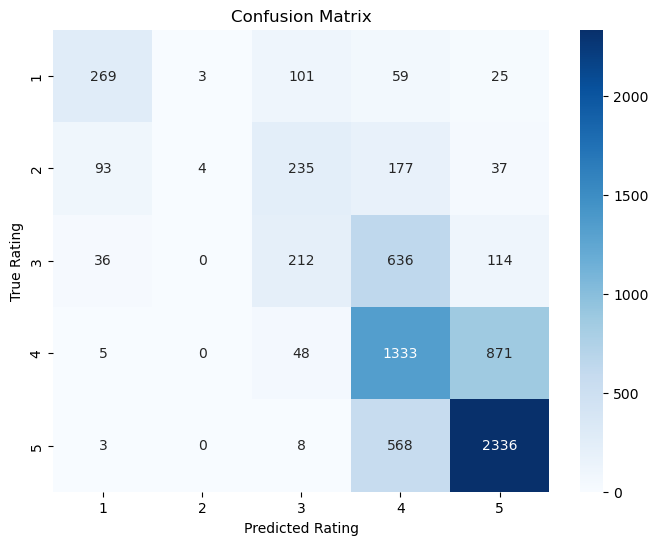

In [285]:
mnb = MultinomialNB()
mnb.fit(X_train_vec, y_train)

y_pred_mnb = mnb.predict(X_test_vec)
mae = mean_absolute_error(y_test, y_pred_mnb)
acc = accuracy_score(y_test, y_pred_mnb)
weighted_f1 = f1_score(y_test, y_pred_mnb, average='weighted')
macro_f1 = f1_score(y_test, y_pred_mnb, average='macro')

print("Multinomial Naive Bayes:")
print(f"Accuracy: {acc:.4f}")
print(f"F1 score: {weighted_f1:.4f}")
print(f"F1 macro score: {macro_f1:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(classification_report(y_test, y_pred_mnb))

con_mat = confusion_matrix(y_test, y_pred_mnb)
plt.figure(figsize=(8, 6))
sns.heatmap(con_mat, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(1, 6),
            yticklabels=range(1, 6))
plt.xlabel('Predicted Rating')
plt.ylabel('True Rating')
plt.title('Confusion Matrix')
plt.show()


In [286]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=50000)
# vectorizer = CountVectorizer(lowercase=True, token_pattern='[a-zA-Z0-9@#$%_]{2,}', \
#                                  max_features=None)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

Normal SVM:
Accuracy: 0.6129
F1 score: 0.6048
F1 macro score: 0.5392
Mean Absolute Error: 0.4364
              precision    recall  f1-score   support

           1       0.63      0.68      0.65       457
           2       0.41      0.22      0.28       546
           3       0.48      0.44      0.46       998
           4       0.54      0.58      0.56      2257
           5       0.72      0.77      0.74      2915

    accuracy                           0.61      7173
   macro avg       0.56      0.53      0.54      7173
weighted avg       0.60      0.61      0.60      7173



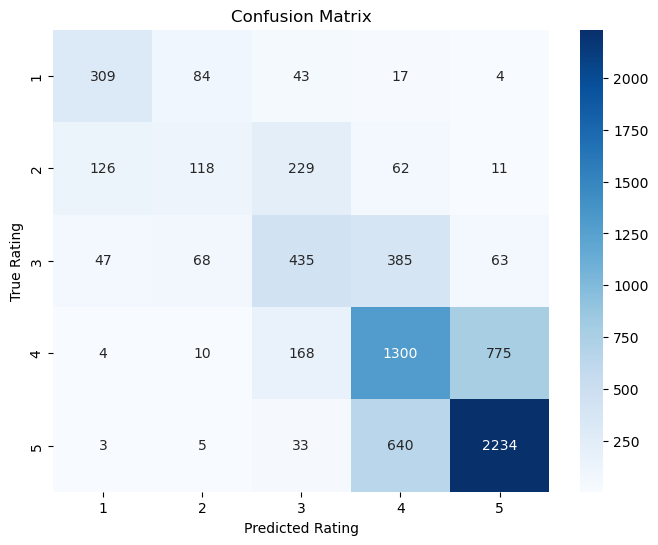

In [287]:
from sklearn.svm import LinearSVC

svm = SVC(kernel='linear', C=1)
svm.fit(X_train_vec, y_train)

y_pred_svm = svm.predict(X_test_vec)
mae = mean_absolute_error(y_test, y_pred_svm)
acc = accuracy_score(y_test, y_pred_svm)
weighted_f1 = f1_score(y_test, y_pred_svm, average='weighted')
macro_f1 = f1_score(y_test, y_pred_svm, average='macro')

print("Normal SVM:")
print(f"Accuracy: {acc:.4f}")
print(f"F1 score: {weighted_f1:.4f}")
print(f"F1 macro score: {macro_f1:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(classification_report(y_test, y_pred_svm))

con_mat = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(con_mat, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(1, 6),
            yticklabels=range(1, 6))
plt.xlabel('Predicted Rating')
plt.ylabel('True Rating')
plt.title('Confusion Matrix')
plt.show()


Normal Logistic Regression:
Accuracy: 0.6166
F1 score: 0.6092
F1 Macro: 0.5484
Mean Absolute Error: 0.4376
              precision    recall  f1-score   support

           1       0.58      0.74      0.65       457
           2       0.39      0.28      0.32       546
           3       0.48      0.47      0.48       998
           4       0.57      0.51      0.54      2257
           5       0.72      0.79      0.75      2915

    accuracy                           0.62      7173
   macro avg       0.55      0.56      0.55      7173
weighted avg       0.61      0.62      0.61      7173



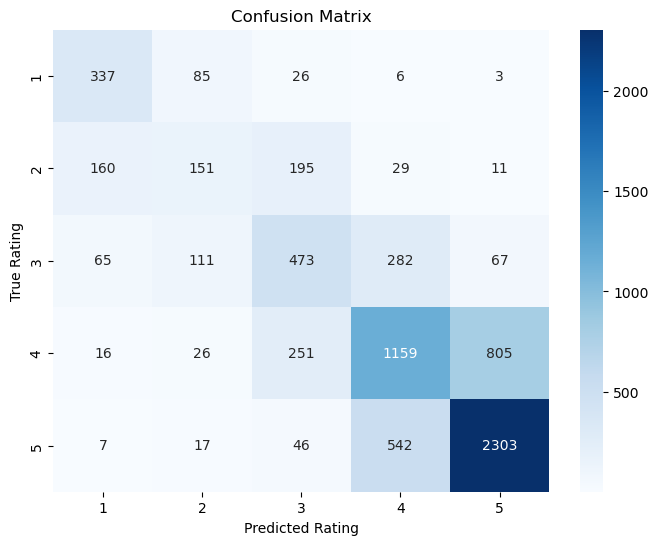

In [288]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(C=1.0, class_weight='balanced', 
                             solver='liblinear', penalty='l2',            
                             max_iter=10000, random_state=42
                             )

log_reg.fit(X_train_vec, y_train)

y_pred_lr = log_reg.predict(X_test_vec)
mae = mean_absolute_error(y_test, y_pred_lr)
acc = accuracy_score(y_test, y_pred_lr)
weighted_f1 = f1_score(y_test, y_pred_lr, average='weighted')
macro_f1 = f1_score(y_test, y_pred_lr, average='macro')

print("Normal Logistic Regression:")
print(f"Accuracy: {acc:.4f}")
print(f"F1 score: {weighted_f1:.4f}")
print(f"F1 Macro: {macro_f1:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")

print(classification_report(y_test, y_pred_lr))

con_mat = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(con_mat, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(1, 6),
            yticklabels=range(1, 6))
plt.xlabel('Predicted Rating')
plt.ylabel('True Rating')
plt.title('Confusion Matrix')
plt.show()


Cross-Validation Scores: [0.59880373 0.58932286 0.59512044 0.60681814 0.60862627]
Mean Stratified CV Score: 0.5997 (±0.0072)
SVM with stratified K-fold validation:
Accuracy: 0.6031
F1 weighted score: 0.5863
F1 Macro: 0.5148
Mean Absolute Error: 0.4654
              precision    recall  f1-score   support

           1       0.62      0.70      0.66       457
           2       0.43      0.15      0.22       546
           3       0.50      0.37      0.42       998
           4       0.52      0.54      0.53      2257
           5       0.70      0.80      0.74      2915

    accuracy                           0.60      7173
   macro avg       0.55      0.51      0.51      7173
weighted avg       0.59      0.60      0.59      7173



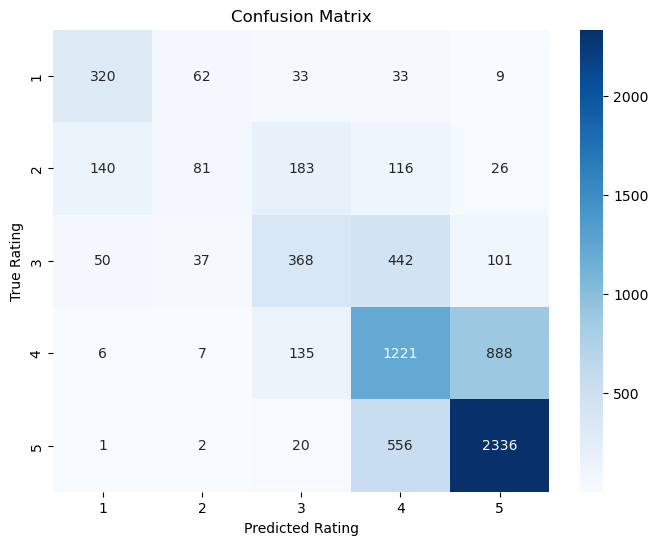

In [289]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.calibration import CalibratedClassifierCV

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 3), max_features=80000)),
    ('model', CalibratedClassifierCV(LinearSVC(C=1, class_weight='balanced')))
])

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
stratified_cv_scores = cross_val_score(pipeline, lem_train_data["lemmatized_text"], 
                                       lem_train_data["overall"], 
                                       cv=stratified_kfold, scoring='f1_weighted')

print(f"Cross-Validation Scores: {stratified_cv_scores}")
print(f"Mean Stratified CV Score: {np.mean(stratified_cv_scores):.4f} (±{np.std(stratified_cv_scores):.4f})")

pipeline.fit(X_train, y_train)

y_pred_svm = pipeline.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_svm)
acc = accuracy_score(y_test, y_pred_svm)
weighted_f1 = f1_score(y_test, y_pred_svm, average='weighted')
macro_f1 = f1_score(y_test,y_pred_svm, average='macro' )

print("SVM with stratified K-fold validation:")
print(f"Accuracy: {acc:.4f}")
print(f"F1 weighted score: {weighted_f1:.4f}")
print(f"F1 Macro: {macro_f1:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(classification_report(y_test, y_pred_svm))

con_mat = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(con_mat, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(1, 6),
            yticklabels=range(1, 6))
plt.xlabel('Predicted Rating')
plt.ylabel('True Rating')
plt.title('Confusion Matrix')
plt.show()


Cross-Validation Scores (Stratified): [0.62944375 0.62254287 0.62756169 0.63208534 0.63375863]
Mean Stratified CV Score: 0.6291 (±0.0039)

Test Set Evaluation:
Accuracy: 0.6166
f1 score: 0.6092

Classification Report:
              precision    recall  f1-score   support

           1       0.58      0.74      0.65       457
           2       0.39      0.28      0.32       546
           3       0.48      0.47      0.48       998
           4       0.57      0.51      0.54      2257
           5       0.72      0.79      0.75      2915

    accuracy                           0.62      7173
   macro avg       0.55      0.56      0.55      7173
weighted avg       0.61      0.62      0.61      7173



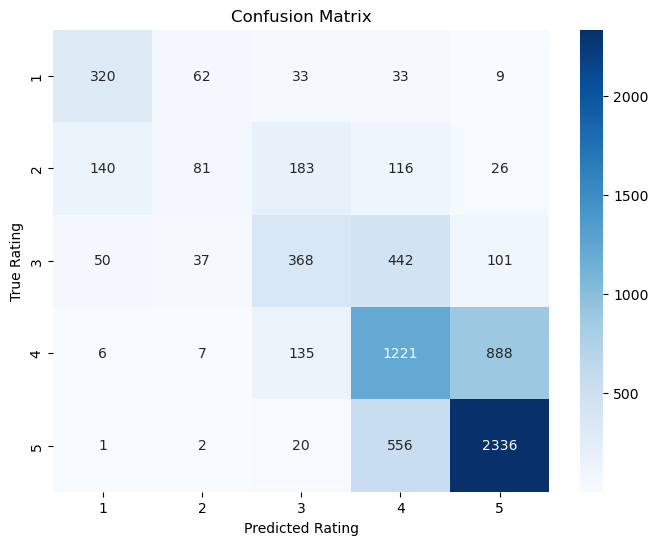

In [290]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,3), max_features=50000)),
    ('model', LogisticRegression(C=1.0, class_weight='balanced', 
                             solver='liblinear', penalty='l2',            
                             max_iter=10000, random_state=42
                             ))
])

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
stratified_cv_scores = cross_val_score(pipeline, lem_train_data["lemmatized_text"], 
                                       lem_train_data["overall"], 
                                       cv=stratified_kfold, scoring='accuracy')

print(f"Cross-Validation Scores (Stratified): {stratified_cv_scores}")
print(f"Mean Stratified CV Score: {np.mean(stratified_cv_scores):.4f} (±{np.std(stratified_cv_scores):.4f})")

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
print("\nTest Set Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"f1 score: {f1_score(y_test, y_pred, average='weighted'):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
plt.figure(figsize=(8, 6))
sns.heatmap(con_mat, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(1, 6),
            yticklabels=range(1, 6))
plt.xlabel('Predicted Rating')
plt.ylabel('True Rating')
plt.title('Confusion Matrix')
plt.show()

Random Forest:
Accuracy: 0.5425
F1 score: 0.4871
Mean Absolute Error: 0.6265
              precision    recall  f1-score   support

           1       0.65      0.54      0.59       457
           2       0.15      0.00      0.01       546
           3       0.34      0.07      0.11       998
           4       0.43      0.49      0.46      2257
           5       0.61      0.85      0.71      2915

    accuracy                           0.54      7173
   macro avg       0.44      0.39      0.38      7173
weighted avg       0.49      0.54      0.49      7173



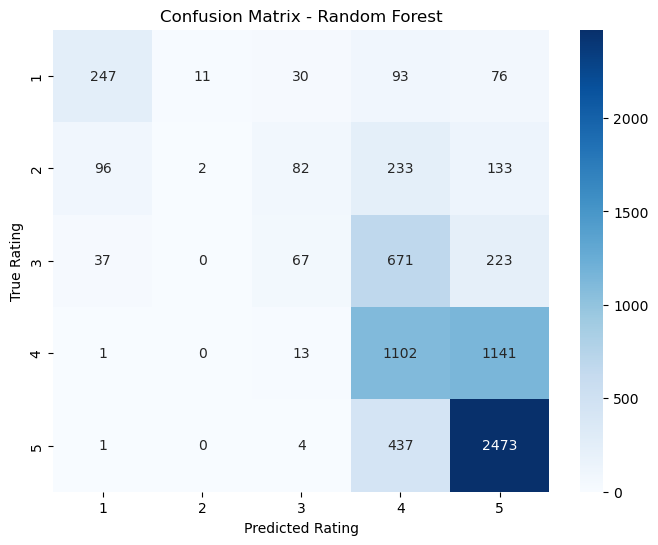

In [291]:
from sklearn.ensemble import RandomForestClassifier
pipeline_rf = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2), max_features=10000)),
    ('model', RandomForestClassifier(
        n_estimators=100,     
        max_depth=None,       
        min_samples_split=2,  
        random_state=42       
    ))
])

pipeline_rf.fit(X_train, y_train)
y_pred_rf = pipeline_rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_rf)
acc = accuracy_score(y_test, y_pred_rf)
weighted_f1 = f1_score(y_test, y_pred_rf, average='weighted')

print("Random Forest:")
print(f"Accuracy: {acc:.4f}")
print(f"F1 score: {weighted_f1:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(classification_report(y_test, y_pred_rf))

con_mat = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(con_mat, annot=True, fmt='d', cmap='Blues',
           xticklabels=range(1, 6),
           yticklabels=range(1, 6))
plt.xlabel('Predicted Rating')
plt.ylabel('True Rating')
plt.title('Confusion Matrix - Random Forest')
plt.show()

In [292]:
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
# !python -m spacy download en_core_web_md

nlp = spacy.load('en_core_web_md')

X_train, X_test, y_train, y_test = train_test_split(
    lem_train_data["lemmatized_text"], 
    lem_train_data["overall"], 
    test_size=0.3, 
    random_state=42
)
print(len(X_train), len(X_test))

16735 7173


Random Forest with word vectors:
Accuracy: 0.4906
F1 score: 0.4520
Mean Absolute Error: 0.6971
              precision    recall  f1-score   support

           1       0.52      0.48      0.50       457
           2       0.28      0.04      0.07       546
           3       0.31      0.11      0.16       998
           4       0.39      0.43      0.41      2257
           5       0.57      0.76      0.65      2915

    accuracy                           0.49      7173
   macro avg       0.42      0.36      0.36      7173
weighted avg       0.45      0.49      0.45      7173



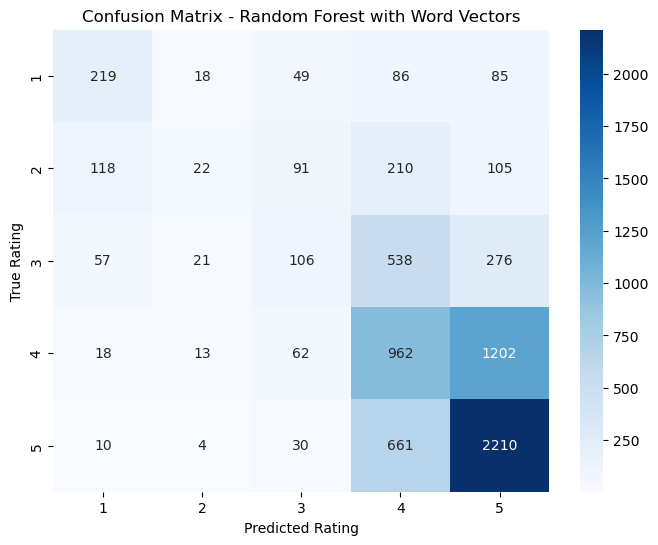

In [293]:
from sklearn.base import BaseEstimator, TransformerMixin

class SpacyVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, model='en_core_web_md'):
        self.model = model
        self.nlp = spacy.load(model)
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array([self.nlp(doc).vector for doc in X])

pipeline_rf_vectors = Pipeline([
    ('word_vectors', SpacyVectorTransformer(model='en_core_web_md')),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        min_samples_split=2,
        random_state=42
    ))
])

pipeline_rf_vectors.fit(X_train, y_train)

y_pred_rf = pipeline_rf_vectors.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_rf)
acc = accuracy_score(y_test, y_pred_rf)
weighted_f1 = f1_score(y_test, y_pred_rf, average='weighted')

print("Random Forest with word vectors:")
print(f"Accuracy: {acc:.4f}")
print(f"F1 score: {weighted_f1:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(classification_report(y_test, y_pred_rf))

con_mat = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(con_mat, annot=True, fmt='d', cmap='Blues',
           xticklabels=range(1, 6),
           yticklabels=range(1, 6))
plt.xlabel('Predicted Rating')
plt.ylabel('True Rating')
plt.title('Confusion Matrix - Random Forest with Word Vectors')
plt.show()

### 4. Experiment with VADER sentiment lexicon

In [294]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# nltk.download('vader_lexicon')

sentiment = SentimentIntensityAnalyzer()

def sentiment_scores(text):
    score = sentiment.polarity_scores(text)
    return score['compound']

lem_train_data.loc[:, 'vader_score'] = lem_train_data['lemmatized_text'].apply(sentiment_scores)
lem_train_data


/tmp/ipykernel_202462/1105961701.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lem_train_data.loc[:, 'vader_score'] = lem_train_data['lemmatized_text'].apply(sentiment_scores)


,overall,clean_title,lemmatized_text,vader_score
0,1,horrible experience,horrible experience first get room book pay di...,0.7717
1,1,stay away,stay away find racist graffiti room request ch...,-0.8225
2,4,great location and service,great location service close union square hote...,0.8360
3,2,I will never go back here again,never go back bad vibe place moment walk main ...,0.9676
4,1,rip off our visa card after departure,rip visa card departure receive final bill lea...,0.6124
...,...,...,...,...
23903,4,pleasant stay with good location,pleasant stay good location stay one night vis...,0.9774
23904,3,hit or miss some thing need attention,hit miss thing need attention spend two night ...,0.9771
23905,5,good breakfast,good breakfast room fairly large pretty quiet ...,0.8689
23906,4,deserve a high rating,deserve high rating great start stay check 2hr...,0.9618


In [295]:
def vader_classification(score):
    if score >= 0.7:
        return 5
    elif score > 0.3:
        return 4
    elif score > -0.3:
        return 3
    elif score >= -0.7:
        return 2
    else:
        return 1
    
lem_train_data.loc[:, 'vader_rating'] = lem_train_data['vader_score'].apply(vader_classification)
lem_train_data['vader_rating']
lem_train_data.loc[:, 'rating_discrepancy'] = abs(lem_train_data['overall'] - lem_train_data['vader_rating'])
lem_train_data

/tmp/ipykernel_202462/2934852324.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lem_train_data.loc[:, 'vader_rating'] = lem_train_data['vader_score'].apply(vader_classification)
/tmp/ipykernel_202462/2934852324.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lem_train_data.loc[:, 'rating_discrepancy'] = abs(lem_train_data['overall'] - lem_train_data['vader_rating'])


,overall,clean_title,lemmatized_text,vader_score,vader_rating,rating_discrepancy
0,1,horrible experience,horrible experience first get room book pay di...,0.7717,5,4
1,1,stay away,stay away find racist graffiti room request ch...,-0.8225,1,0
2,4,great location and service,great location service close union square hote...,0.8360,5,1
3,2,I will never go back here again,never go back bad vibe place moment walk main ...,0.9676,5,3
4,1,rip off our visa card after departure,rip visa card departure receive final bill lea...,0.6124,4,3
...,...,...,...,...,...,...
23903,4,pleasant stay with good location,pleasant stay good location stay one night vis...,0.9774,5,1
23904,3,hit or miss some thing need attention,hit miss thing need attention spend two night ...,0.9771,5,2
23905,5,good breakfast,good breakfast room fairly large pretty quiet ...,0.8689,5,0
23906,4,deserve a high rating,deserve high rating great start stay check 2hr...,0.9618,5,1


In [296]:
mean_discrepancy = lem_train_data['rating_discrepancy'].mean()
print(f"The average discrepancy between vader sentiment rating based on text and ground truth rating given by customer is: {mean_discrepancy:.4f}")

The average discrepancy between vader sentiment rating based on text and ground truth rating given by customer is: 0.8468


accuracy: 0.4423
precision: 0.3469
recall: 0.4423
f1_weighted: 0.3155
              precision    recall  f1-score   support

           1       0.69      0.28      0.40      1540
           2       0.28      0.08      0.13      1600
           3       0.25      0.05      0.08      3274
           4       0.19      0.02      0.04      7690
           5       0.46      0.98      0.62      9804

    accuracy                           0.44     23908
   macro avg       0.37      0.28      0.26     23908
weighted avg       0.35      0.44      0.32     23908



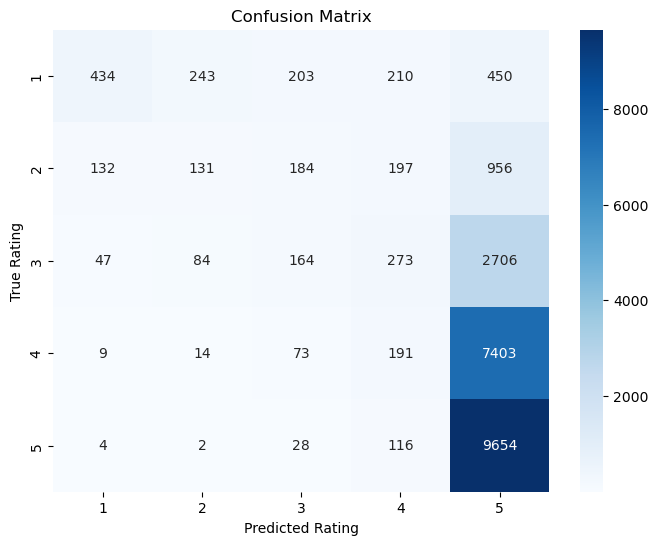

In [297]:
y_true, y_pred = lem_train_data['overall'], lem_train_data['vader_rating']

accuracy = accuracy_score(y_true, y_pred)
precision_weighted = precision_score(y_true, y_pred, average='weighted')
recall_weighted = recall_score(y_true, y_pred, average='weighted')
f1_weighted = f1_score(y_true, y_pred, average='weighted')

print(f'accuracy: {accuracy:.4f}')
print(f'precision: {precision_weighted:.4f}')
print(f'recall: {recall_weighted:.4f}')
print(f'f1_weighted: {f1_weighted:.4f}')

print(classification_report(y_true, y_pred))

con_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(con_mat, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(1, 6),
            yticklabels=range(1, 6))
plt.xlabel('Predicted Rating')
plt.ylabel('True Rating')
plt.title('Confusion Matrix')
plt.show()

### 5. Final testing on test set and discussion of results

### 6. Propose a method to predict aspects 

***(COMP SCI 7417 and COMP SCI 7717 only)***

### 7. Reflection on the ***Product*** development.

### 9. References

### Appendix